In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True


DATA_DIR = Path("/kaggle/input/MABe-mouse-behavior-detection") 
print("Using DATA_DIR:", DATA_DIR.resolve())

Using DATA_DIR: /kaggle/input/MABe-mouse-behavior-detection


In [3]:
train_meta_path = DATA_DIR / "train.csv"
test_meta_path  = DATA_DIR / "test.csv"
TRAIN_ANN_DIR = DATA_DIR / "train_annotation"
assert train_meta_path.exists(), f"Missing {train_meta_path}"
assert test_meta_path.exists(),  f"Missing {test_meta_path}"

train_meta = pd.read_csv(train_meta_path)
test_meta  = pd.read_csv(test_meta_path)
print("train_meta shape:", train_meta.shape)
display(train_meta.head())

train_meta shape: (8789, 38)


,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
1,AdaptableSnail,143861384,CD-1 (ICR),white,male,3.0,8-12 weeks,NaN,CD-1 (ICR),white,...,9.7,968,608,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
2,AdaptableSnail,209576908,CD-1 (ICR),white,male,7.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1266,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
3,AdaptableSnail,278643799,CD-1 (ICR),white,male,11.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1224,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
4,AdaptableSnail,351967631,CD-1 (ICR),white,male,14.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1204,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


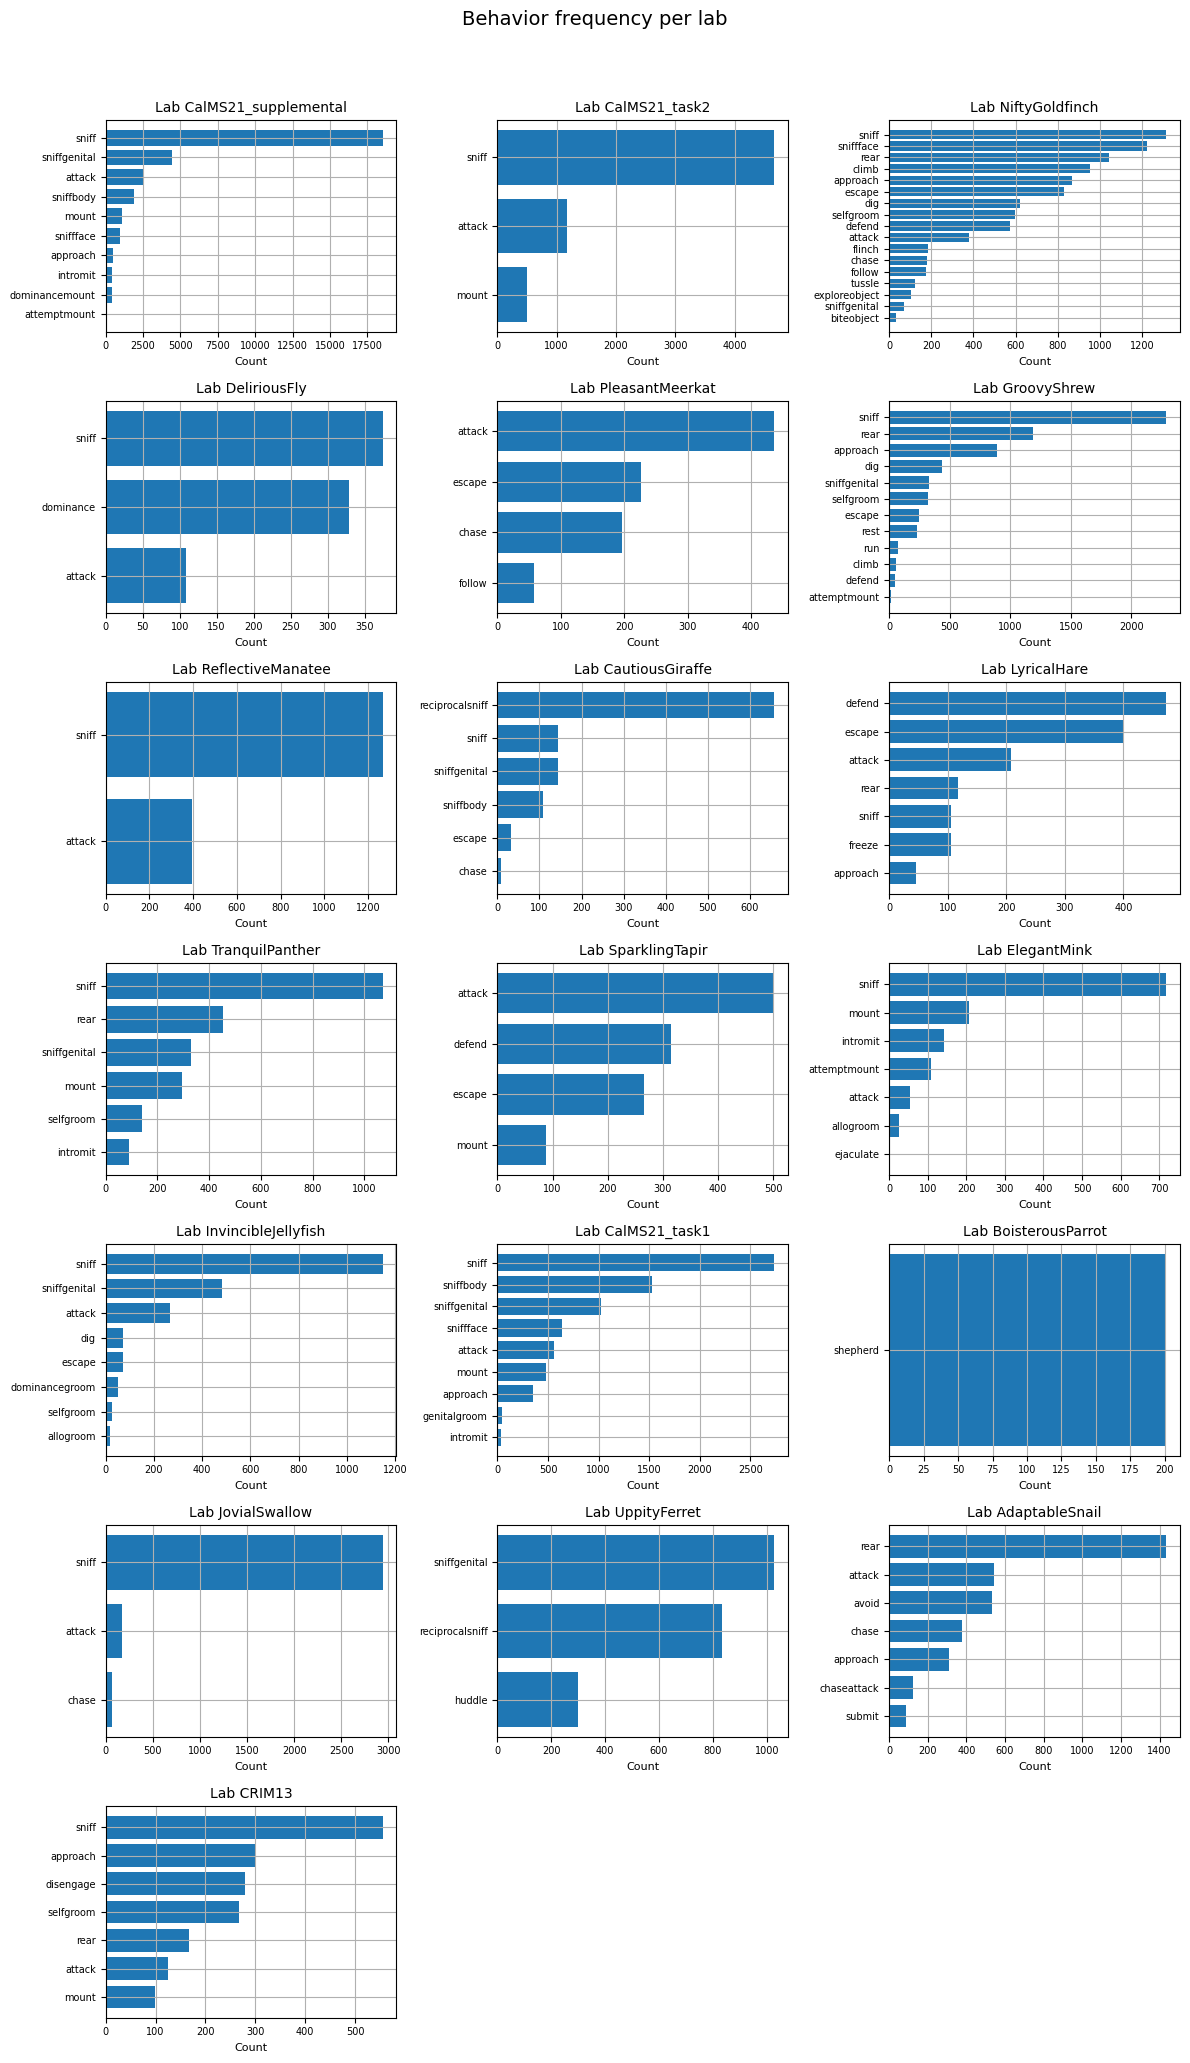

In [7]:
import math
import polars as pl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

rows = []

for lab_dir in TRAIN_ANN_DIR.iterdir():
    if not lab_dir.is_dir():
        continue

    lab_id = lab_dir.name

    for ann_file in lab_dir.glob("*.parquet"):
        ann = pl.read_parquet(ann_file)

        # nhanh hơn: lấy list luôn
        for b in ann["action"].to_list():
            rows.append({"lab_id": lab_id, "action": b})

count_df = (
    pl.DataFrame(rows)
    .group_by(["lab_id", "action"])
    .len()
    .rename({"len": "num_occurrences"})
)

labs = count_df["lab_id"].unique().to_list()
n_labs = len(labs)

n_cols = 3
n_rows = math.ceil(n_labs / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=False
)

axes = axes.flatten()


for i, lab_id in enumerate(labs[:len(axes)]):
    ax = axes[i]

    sub = (
        count_df
        .filter(pl.col("lab_id") == lab_id)
        .sort("num_occurrences")
    )

    ax.barh(sub["action"].to_list(), sub["num_occurrences"].to_list())
    ax.set_title(f"Lab {lab_id}", fontsize=10)
    ax.set_xlabel("Count", fontsize=8)
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=7)


for j in range(len(labs), len(axes)):
    axes[j].axis("off")

fig.suptitle("Behavior frequency per lab", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Biểu đồ so sánh số lần xuất hiện của của từng action theo từng lab -> cho thấy sự mất cân bằng giữa các nhãn

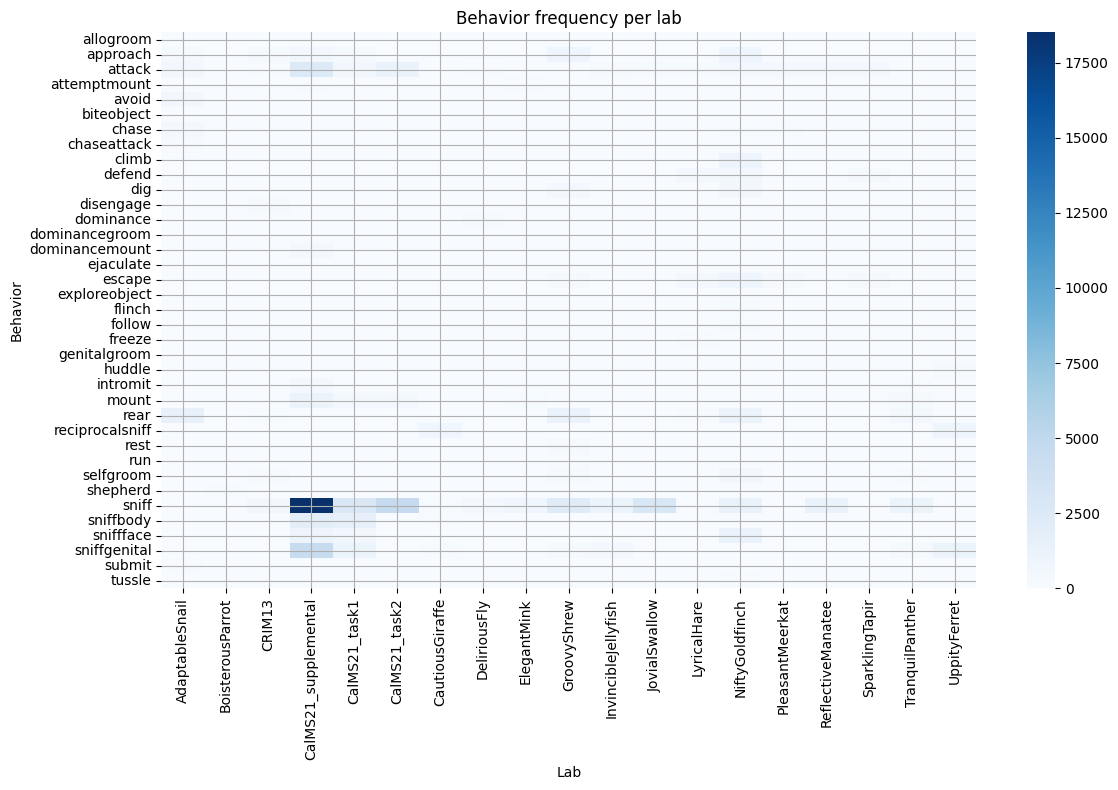

In [9]:
pivot = count_df.to_pandas().pivot(
    index="action",
    columns="lab_id",
    values="num_occurrences"
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap="Blues")
plt.title("Behavior frequency per lab")
plt.xlabel("Lab")
plt.ylabel("Behavior")
plt.tight_layout()
plt.show()


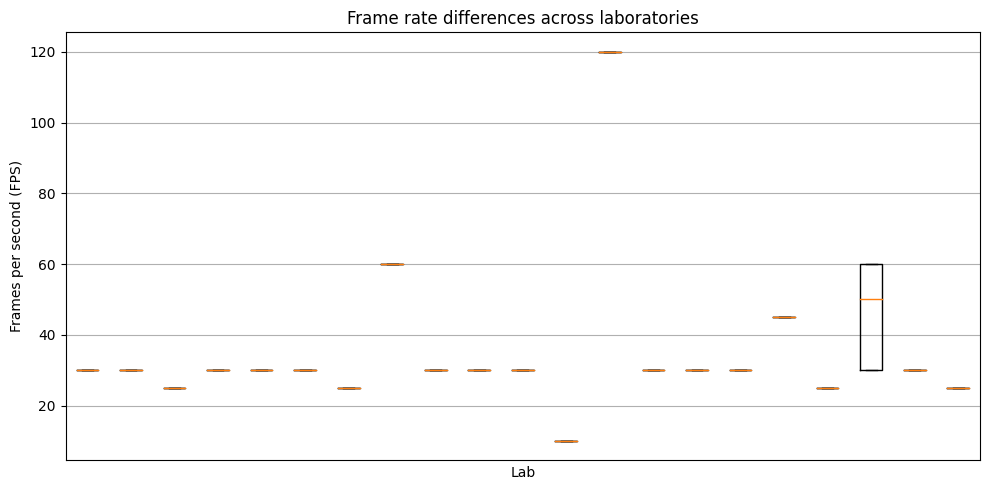

In [10]:

fps = train_meta[["lab_id", "frames_per_second"]].dropna()
import matplotlib.pyplot as plt

labs = sorted(fps["lab_id"].unique())
data = [fps[fps["lab_id"] == lab]["frames_per_second"] for lab in labs]

plt.figure(figsize=(10, 5))
plt.boxplot(data, showfliers=False)
plt.xlabel("Lab")
plt.ylabel("Frames per second (FPS)")
plt.title("Frame rate differences across laboratories")

plt.xticks([])
plt.tight_layout()
plt.show()

In [11]:
train_ann_ex = pd.read_parquet("/kaggle/input/MABe-mouse-behavior-detection/train_annotation/AdaptableSnail/1212811043.parquet")
train_ann_ex.head(5)

,agent_id,target_id,action,start_frame,stop_frame
0,1,3,chase,2,54
1,1,3,chase,128,234
2,3,2,avoid,324,342
3,3,1,avoid,324,342
4,1,2,chase,942,1052


In [12]:
train_track_ex = pd.read_parquet("/kaggle/input/MABe-mouse-behavior-detection/train_tracking/AdaptableSnail/1212811043.parquet")
train_track_ex.head(5)

,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,496.187012,376.475006
1,0,1,ear_left,494.059998,343.924011
2,0,1,ear_right,518.765015,367.362000
3,0,1,lateral_left,474.536987,370.563995
4,0,1,lateral_right,505.825012,394.937012


In [13]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8789 entries, 0 to 8788
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lab_id              8789 non-null   object 
 1   video_id            8789 non-null   int64  
 2   mouse1_strain       8789 non-null   object 
 3   mouse1_color        8789 non-null   object 
 4   mouse1_sex          8779 non-null   object 
 5   mouse1_id           816 non-null    float64
 6   mouse1_age          8140 non-null   object 
 7   mouse1_condition    8229 non-null   object 
 8   mouse2_strain       8789 non-null   object 
 9   mouse2_color        8789 non-null   object 
 10  mouse2_sex          8742 non-null   object 
 11  mouse2_id           108 non-null    float64
 12  mouse2_age          8140 non-null   object 
 13  mouse2_condition    7991 non-null   object 
 14  mouse3_strain       7943 non-null   object 
 15  mouse3_color        7943 non-null   object 
 16  mouse3

Dataset có 8789 dòng, mỗi dòng là một video (hoặc một session).
Có 38 cột, chia thành các nhóm:
Mỗi video có thể có 2–4 con chuột: mouse1, mouse2, mouse3, mouse4
Nhưng đa số video chỉ có 2 con chuột → vì thế nhiều cột của mouse3/mouse4 bị NaN.
mouseX_id: ID chuột riêng biệt. Rất nhiều NaN vì nhiều lab không gắn ID.

mouse3_* chỉ có ~7,900 bản ghi → chứng tỏ trong ~800 video không có mouse3.
mouse4_* gần như toàn bộ NaN → chỉ vài video có 4 con chuột.

behaviors_labeled: Chỉ định behavior nào được gán nhãn trong video
Chỉ có 848 video có nhãn hành vi (out of 8789) → còn lại không có nhãn

In [15]:
n_labs = train_meta["lab_id"].nunique() if "lab_id" in train_meta.columns else np.nan
n_videos = train_meta["video_id"].nunique() if "video_id" in train_meta.columns else np.nan
print({"labs": n_labs, "videos": n_videos})
display(train_meta.describe(include="all").transpose())

{'labs': 21, 'videos': 8789}


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
lab_id,8789,21,MABe22_keypoints,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_id,8789.0,NaN,NaN,NaN,1072696654.285698,620981953.24735,9603.0,538093977.0,1072003239.0,1615401199.0,2147479224.0
mouse1_strain,8789,8,C57Bl/6J,5313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse1_color,8789,4,black,5418,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse1_sex,8779,2,male,8729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse1_id,816.0,NaN,NaN,NaN,24.571078,22.444201,1.0,6.0,15.0,38.0,80.0
mouse1_age,8140,8,10-20 weeks,7926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse1_condition,8229,3752,cabled device,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse2_strain,8789,8,C57Bl/6J,4823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse2_color,8789,4,black,4831,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train_meta.behaviors_labeled[0]

'["mouse1,mouse2,approach", "mouse1,mouse2,attack", "mouse1,mouse2,avoid", "mouse1,mouse2,chase", "mouse1,mouse2,chaseattack", "mouse1,mouse2,submit", "mouse1,mouse3,approach", "mouse1,mouse3,attack", "mouse1,mouse3,avoid", "mouse1,mouse3,chase", "mouse1,mouse3,chaseattack", "mouse1,mouse3,submit", "mouse1,mouse4,approach", "mouse1,mouse4,attack", "mouse1,mouse4,avoid", "mouse1,mouse4,chase", "mouse1,mouse4,chaseattack", "mouse1,mouse4,submit", "mouse1,self,rear", "mouse2,mouse1,approach", "mouse2,mouse1,attack", "mouse2,mouse1,avoid", "mouse2,mouse1,chase", "mouse2,mouse1,chaseattack", "mouse2,mouse1,submit", "mouse2,mouse3,approach", "mouse2,mouse3,attack", "mouse2,mouse3,avoid", "mouse2,mouse3,chase", "mouse2,mouse3,chaseattack", "mouse2,mouse3,submit", "mouse2,mouse4,approach", "mouse2,mouse4,attack", "mouse2,mouse4,avoid", "mouse2,mouse4,chase", "mouse2,mouse4,chaseattack", "mouse2,mouse4,submit", "mouse2,self,rear", "mouse3,mouse1,approach", "mouse3,mouse1,attack", "mouse3,mouse1

In [18]:
train_meta.lab_id.value_counts()

lab_id
MABe22_keypoints        5320
MABe22_movies           2606
CalMS21_supplemental     297
CalMS21_task1            101
CalMS21_task2             76
SparklingTapir            69
JovialSwallow             52
PleasantMeerkat           36
InvincibleJellyfish       33
TranquilPanther           25
LyricalHare               24
UppityFerret              21
CRIM13                    21
ReflectiveManatee         20
ElegantMink               19
GroovyShrew               17
AdaptableSnail            17
NiftyGoldfinch            11
CautiousGiraffe           10
BoisterousParrot           8
DeliriousFly               6
Name: count, dtype: int64

In [19]:
import ast
col = "behaviors_labeled"
vid_col = "video_id"

records = []
skipped = 0
for i, row in train_meta.iterrows():
    s = row.get(col, None)
    vid = row.get(vid_col, None)
    if pd.isna(s):
        continue
    try:
        items = ast.literal_eval(s)
        if not isinstance(items, (list, tuple)):
            skipped += 1
            continue
        for it in items:
            parts = str(it).split(",")
            if len(parts) != 3:
                continue
            agent, target, behavior = [p.strip().strip("'\"") for p in parts]
            records.append({"video_id": vid, "agent": agent, "target": target, "behavior": behavior})
    except Exception:
        skipped += 1

df_beh = pd.DataFrame.from_records(records)
print("Parsed rows:", len(df_beh), "| Skipped rows:", skipped)
display(df_beh.head())

Parsed rows: 4919 | Skipped rows: 0


,video_id,agent,target,behavior
0,44566106,mouse1,mouse2,approach
1,44566106,mouse1,mouse2,attack
2,44566106,mouse1,mouse2,avoid
3,44566106,mouse1,mouse2,chase
4,44566106,mouse1,mouse2,chaseattack


In [21]:
lab_id_exp = "AdaptableSnail"
video_id_exp = 44566106

In [22]:
train_meta[(train_meta.lab_id == lab_id_exp) & (train_meta.video_id == video_id_exp)]

,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


In [23]:
df_beh[df_beh.video_id == video_id_exp].groupby(["agent", "target"]).size()

agent   target
mouse1  mouse2    6
        mouse3    6
        mouse4    6
        self      1
mouse2  mouse1    6
        mouse3    6
        mouse4    6
        self      1
mouse3  mouse1    6
        mouse2    6
        mouse4    6
        self      1
mouse4  mouse1    6
        mouse2    6
        mouse3    6
        self      1
dtype: int64

In [24]:
df_beh[df_beh.video_id == video_id_exp]

,video_id,agent,target,behavior
0,44566106,mouse1,mouse2,approach
1,44566106,mouse1,mouse2,attack
2,44566106,mouse1,mouse2,avoid
3,44566106,mouse1,mouse2,chase
4,44566106,mouse1,mouse2,chaseattack
...,...,...,...,...
71,44566106,mouse4,mouse3,avoid
72,44566106,mouse4,mouse3,chase
73,44566106,mouse4,mouse3,chaseattack
74,44566106,mouse4,mouse3,submit


Tìm file tracking .parquet tương ứng với video -> Load tracking vào DataFrame -> Kiểm tra định dạng tracking -> Vẽ quỹ đạo chuyển động (trajectory) của 1 bodypart của 1 con chuột

Sample tracking file: /kaggle/input/MABe-mouse-behavior-detection/train_tracking/AdaptableSnail/44566106.parquet


,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,1161.543945,523.112976
1,0,1,ear_right,1146.305054,587.619995
2,0,1,headpiece_bottomfrontright,1163.192017,588.580017
3,0,1,headpiece_topbackright,1192.211060,558.434998
4,0,1,headpiece_topfrontleft,1191.343994,620.625977


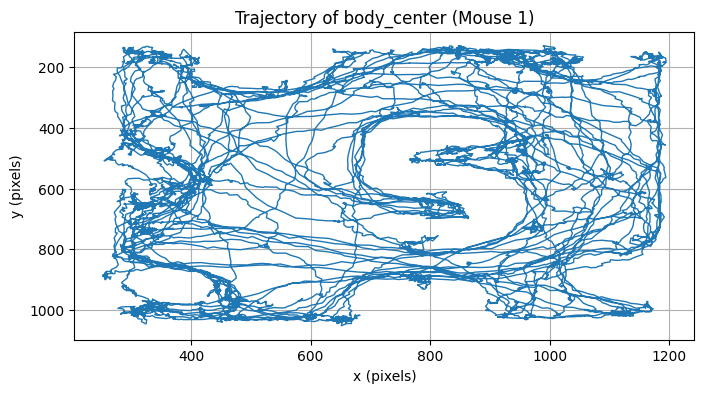

In [25]:
track_dir = DATA_DIR /'train_tracking'/lab_id_exp
sample_track = None
if track_dir.exists():
    # try to find a parquet named after a train video_id
    cand = track_dir / f"{video_id_exp}.parquet"
    if cand.exists():
        sample_track = cand
    # or just take any parquet in the folder
    if sample_track is None:
        pq_files = list(track_dir.glob("*.parquet"))
        if pq_files:
            sample_track = pq_files[0]

if sample_track is not None:
    print("Sample tracking file:", sample_track)
    try:
        df_track = pd.read_parquet(sample_track)
    except Exception as e:
        print("Parquet read error:", e)
        df_track = None
else:
    print("No tracking parquet found under", track_dir)
    df_track = None

if df_track is not None and not df_track.empty:
    display(df_track.head())
    cols = df_track.columns.tolist()
    need = {"video_frame", "mouse_id", "bodypart", "x", "y"}
    if need.issubset(set(cols)):
        mouse0 = df_track["mouse_id"].iloc[0]
        body0 = df_track["bodypart"].iloc[0]
        path_df = df_track[(df_track["mouse_id"] == mouse0) & (df_track["bodypart"] == body0)]#.head(500)
        plt.plot(path_df["x"].values, path_df["y"].values, linewidth=1)
        plt.gca().invert_yaxis()
        plt.title(f"Trajectory of {body0} (Mouse {mouse0})")
        plt.xlabel("x (pixels)")
        plt.ylabel("y (pixels)")
        plt.show()
    else:
        print("Expected tracking columns not found. Got:", cols)

In [26]:
print(df_track.shape)
df_track

(1087658, 5)


,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,1161.543945,523.112976
1,0,1,ear_right,1146.305054,587.619995
2,0,1,headpiece_bottomfrontright,1163.192017,588.580017
3,0,1,headpiece_topbackright,1192.211060,558.434998
4,0,1,headpiece_topfrontleft,1191.343994,620.625977
...,...,...,...,...,...
1087653,18450,4,lateral_left,250.681000,646.434021
1087654,18450,4,lateral_right,297.471985,679.210022
1087655,18450,4,tail_base,265.600006,688.062012
1087656,18450,4,tail_midpoint,263.371002,748.155029


# **# Exploring Annotation File**# 

In [27]:
annotation_dir = DATA_DIR /'train_annotation'/lab_id_exp

In [28]:
annotation_data = pd.read_parquet(annotation_dir/ f"{video_id_exp}.parquet")
print(annotation_data.shape)
annotation_data.head()

(342, 5)


,agent_id,target_id,action,start_frame,stop_frame
0,2,2,rear,4,139
1,4,2,avoid,13,52
2,4,4,rear,121,172
3,3,3,rear,156,213
4,4,4,rear,208,261


In [29]:
print(annotation_data.agent_id.unique())
annotation_data.agent_id.value_counts()

[2 4 3 1]


agent_id
3    117
1     94
4     72
2     59
Name: count, dtype: int64

In [30]:
annotation_data.start_frame.min(), annotation_data.start_frame.max()

(4, 18320)

In [31]:
annotation_data.stop_frame.min(), annotation_data.stop_frame.max()

(52, 18363)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_action_trajectory(track_parquet,
                           ann_parquet,
                           action_idx=0,
                           bodypart=None,
                           max_points=None):
    """
    Plot agent and target trajectories for one annotated action.
    - track_parquet: path to <video_id>.parquet with columns [video_frame, mouse_id, bodypart, x, y]
    - ann_parquet:   path to <video_id>.parquet with columns [agent_id, target_id, action, start_frame, stop_frame]
    - action_idx:    which row in the annotations to plot (after any external filtering)
    - bodypart:      e.g. 'nose' or 'center'. If None, uses centroid over all bodyparts per (frame, mouse).
    - max_points:    optionally limit number of plotted points for readability
    """
    track_parquet = Path(track_parquet)
    ann_parquet   = Path(ann_parquet)

    df_track = pd.read_parquet(track_parquet)
    df_ann   = pd.read_parquet(ann_parquet)

    assert len(df_ann) > action_idx, f"action_idx {action_idx} out of range (len={len(df_ann)})"
    ann = df_ann.iloc[action_idx]

    agent_id = int(ann["agent_id"])
    target_id = int(ann["target_id"])
    start_f = int(ann["start_frame"])
    stop_f  = int(ann["stop_frame"])
    action  = str(ann["action"])

    # Slice the time window
    mask_t = (df_track["video_frame"] >= start_f) & (df_track["video_frame"] <= stop_f)
    dfw = df_track.loc[mask_t].copy()

    # Harmonize dtypes
    dfw["mouse_id"] = pd.to_numeric(dfw["mouse_id"], errors="coerce").astype("Int64")

    # Either pick one bodypart, or compute centroid per (frame, mouse)
    if bodypart is not None and bodypart in dfw["bodypart"].unique():
        dfw = dfw[dfw["bodypart"] == bodypart]
        # Keep one row per (frame, mouse)
        dfw = dfw.sort_values(["mouse_id", "video_frame"])
    else:
        # centroid across available bodyparts at each (frame, mouse)
        dfw = (
            dfw.groupby(["video_frame", "mouse_id"], as_index=False)[["x","y"]]
               .mean()
               .sort_values(["mouse_id", "video_frame"])
        )

    # Extract trajectories
    traj_agent  = dfw[dfw["mouse_id"] == agent_id].copy()
    traj_target = dfw[dfw["mouse_id"] == target_id].copy()

    if max_points is not None:
        traj_agent  = traj_agent.iloc[::max(1, len(traj_agent)//max_points or 1)]
        traj_target = traj_target.iloc[::max(1, len(traj_target)//max_points or 1)]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    if agent_id == target_id:
        ax.plot(traj_agent["x"], traj_agent["y"], linewidth=2, label=f"agent=target={agent_id}")
        if not traj_agent.empty:
            ax.scatter(traj_agent["x"].iloc[0],  traj_agent["y"].iloc[0],  marker="o", s=60, label="start")
            ax.scatter(traj_agent["x"].iloc[-1], traj_agent["y"].iloc[-1], marker="X", s=80, label="end")
    else:
        ax.plot(traj_agent["x"],  traj_agent["y"],  linewidth=2, label=f"agent {agent_id}")
        ax.plot(traj_target["x"], traj_target["y"], linewidth=2, label=f"target {target_id}")
        if not traj_agent.empty:
            ax.scatter(traj_agent["x"].iloc[0],  traj_agent["y"].iloc[0],  marker="o", s=60, label="agent start")
            ax.scatter(traj_agent["x"].iloc[-1], traj_agent["y"].iloc[-1], marker="X", s=80, label="agent end")
        if not traj_target.empty:
            ax.scatter(traj_target["x"].iloc[0],  traj_target["y"].iloc[0],  marker="o", s=60, label="target start")
            ax.scatter(traj_target["x"].iloc[-1], traj_target["y"].iloc[-1], marker="X", s=80, label="target end")

    # Image coordinates: y grows downward → invert Y for natural overlay feel
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_title(f"{track_parquet.stem} — {action} | frames {start_f}–{stop_f}"
                 + (f" | bodypart='{bodypart}'" if bodypart else " | centroid"))
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.legend(
        loc="upper left",          # anchor point of the legend box itself
        bbox_to_anchor=(1.02, 1),  # position relative to the axes (1.02 → just outside right)
        borderaxespad=0,           # small padding
        frameon=True               # optional: show border
    )
    plt.tight_layout()
    plt.show()

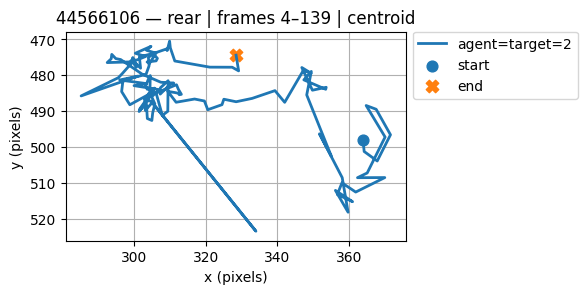

In [33]:
video_id = "44566106"  # example
track_path = f"{track_dir}/{video_id_exp}.parquet"
ann_path   =  f"{annotation_dir}/{video_id_exp}.parquet"

# 1) Plot the first annotation using centroid across bodyparts
plot_action_trajectory(track_path, ann_path)

Đường liên tục màu xanh là đường đi (trajectory) của con chuột trong khoảng từ frame 4 đến frame 139.

Mỗi đoạn thể hiện vị trí chuột dịch chuyển theo thời gian (x,y trong toạ độ pixel).

→ Nhìn chung:

Chuột di chuyển nhiều, đổi hướng liên tục

Có lúc đứng yên, lúc chạy vòng lại

In [34]:
annotation_data[(annotation_data.agent_id == 1)& (annotation_data.target_id== 3)].sort_values("start_frame")

,agent_id,target_id,action,start_frame,stop_frame
17,1,3,avoid,924,981
47,1,3,approach,3111,3122
128,1,3,avoid,7599,7619
137,1,3,approach,7999,8016
179,1,3,avoid,9746,9774
194,1,3,approach,10835,10870
218,1,3,approach,11718,11731
222,1,3,submit,11893,11944
267,1,3,approach,14601,14612
289,1,3,approach,15765,15774


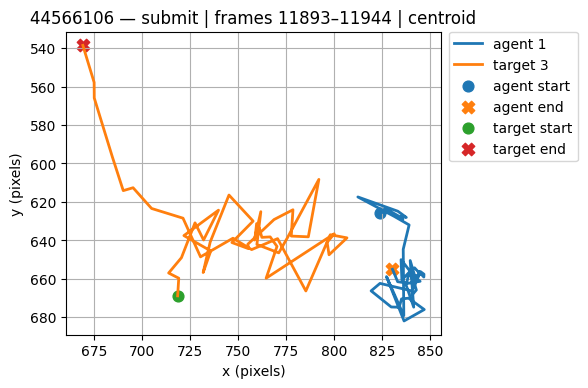

In [35]:
plot_action_trajectory(track_path, ann_path, action_idx = 222)